# Fully Convolutional Neural Networks




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Introduction

In this notebook you'll convert a convolutional neural network with fully connected layers
into a fully convolutional neural network.

## Requirements

You should have a basic knowledge about:


- *Receptive field*
https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807

- Fully Convolutional Networks
https://www.youtube.com/watch?v=XdsmlBGOK-k&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=26

#### CNN for MNIST classification 

We start with a simple Convolutional Neural Network for classification of the MNIST dataset.

The CNN and training code etc. is adapted from the pytorch examples https://github.com/pytorch/examples/blob/master/mnist/main.py.

In [2]:
in_padding=2
f_size=int((28+2*in_padding)/2)
print(f_size)
in_linear_1 = (f_size**2)*64
in_linear_1

16


16384

In [3]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),  
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2, stride=None),
    nn.Dropout(0.25),
    nn.Flatten(), 
    nn.Linear(in_linear_1, 128), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10), 
    nn.LogSoftmax(dim=1)
)

In [4]:
X = torch.randn(1, 1, 28+2*in_padding, 28+2*in_padding)
for layer in model:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 32, 32, 32])
ReLU Output shape:	 torch.Size([1, 32, 32, 32])
Conv2d Output shape:	 torch.Size([1, 64, 32, 32])
ReLU Output shape:	 torch.Size([1, 64, 32, 32])
MaxPool2d Output shape:	 torch.Size([1, 64, 16, 16])
Dropout Output shape:	 torch.Size([1, 64, 16, 16])
Flatten Output shape:	 torch.Size([1, 16384])
Linear Output shape:	 torch.Size([1, 128])
ReLU Output shape:	 torch.Size([1, 128])
Dropout Output shape:	 torch.Size([1, 128])
Linear Output shape:	 torch.Size([1, 10])
LogSoftmax Output shape:	 torch.Size([1, 10])


#### Task

What is the size of the *receptive field* (w.r.t. the input):
1. of the feature map after the first conv-layer
2. of the feature map after the second conv-layer
3. of the feature map after the maxpool-layer
4. of a unit (neuron) in the fully connected layer

Answer the following question:

- Has the stride of the max-pool layer an influence on the size of the 
receptive field of the feature map after the maxpool-layer?

Now, the network is trained on MNIST:

In [5]:
seed = 42
batch_size=64
test_batch_size=1024
no_cuda = False

lr=1.0 # learning rate
gamma = 0.7 # for learning rate scheduler

epochs=3

save_model=False
log_interval=100
dry_run=False

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


In [7]:
def test(model, device, test_loader, is_fully_conv=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if is_fully_conv:
                output = output.reshape(-1, 10)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [8]:
# you have to change the path!
DATA_PATH="/home/chris/data/mnist/"

In [9]:
transform=transforms.Compose([
        transforms.Pad(in_padding, fill=0),
        #transforms.RandomCrop(28+2*in_padding),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST(DATA_PATH, train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(DATA_PATH, train=False, download=True, transform=transform)
 

In [10]:
use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
    
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [11]:
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = model.to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301482
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.329589
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.172428
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.366273
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.187712
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.075119
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.082047
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.231123
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.245059
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.278103

Test set: Average loss: 0.0462, Accuracy: 9843/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033625
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.131078
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.056697
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.142806
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.068464
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.101775
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.119021
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.098635
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.194337
T

### Convert the CNN into a fully convolutional neural network.

Now, we want to convert the `model` into a fully convolutional neural network.


In [12]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25, inplace=False)
  (6): Flatten()
  (7): Linear(in_features=16384, out_features=128, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=128, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)

The first part is identically to the model above.

In [13]:

fcnn_1 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=None),
    nn.Dropout(0.25)
)

In [14]:
# Here we copy the parameters of the cnn layers of the trained model to fcnn_1:
for target_param, param in zip(fcnn_1.parameters(), model.parameters()):
        target_param.data.copy_(param.data)

In [16]:
# YOUR TASK
# Construct the second part as fully convolutional
fcnn_2 = nn.Sequential(
    
    # nn.Flatten(), 
    #nn.Linear(in_linear_1, 128) ->
    #YOUR CODE_HERE
    
    nn.ReLU(),
    nn.Dropout(0.5),
    
    # nn.Linear(128, 10) ->
    #YOUR CODE_HERE
    
    nn.LogSoftmax(dim=1)
)

In [18]:
# Get the parameters (weights and biases) of the fully connected layers
def get_linear_params(layer):
    return layer.weight, layer.bias
W1, b1 = get_linear_params(model[7])
W2, b2 = get_linear_params(model[10])

#### Task

Copy the parameters of the fully connected layers to the conv-layers of the second part of
the fully convolutional NN.

In [21]:
# Now, we connect the first and second part to an fully convolutional NN.
fcnn=nn.Sequential(fcnn_1, fcnn_2)

Test the classification performance. 
You should get the same result as with `model`.


In [23]:
test(fcnn, device, test_loader, is_fully_conv=True)


Test set: Average loss: 0.0366, Accuracy: 9879/10000 (99%)



#### Application to a larger image

Now we construct a larger image with many numbers: 
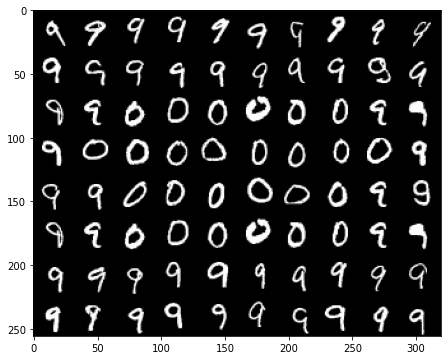

We want to use the fully convolutional neural network to predict all numbers with a
forward pass:

    tensor([[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
             [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
             [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
             [9, 0, 0, 0, 0, 0, 0, 0, 0, 9],
             [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
             [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
             [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
             [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]])



#### Task

Modify your fully convolutional layer such that it accepts the larger image as input
and it predicts such an classification array.

Use a input the large image. Don't reshape the image!

Hint: Change the `stride` such that it corresponds to an (no-overlap) sliding window (on a feature map). 


In [24]:
#testloader = torch.utils.data.DataLoader(dataset, **test_kwargs)
test(fcnn, device, test_loader, is_fully_conv=True)


Test set: Average loss: 0.0366, Accuracy: 9879/10000 (99%)



In [26]:
# construct the large image
nine=[]
zero=[]
n=0
z=0
for x,y in dataset2:
    if y==9:
        nine.append(x)
        n+=1
    if y==0:
        zero.append(x)# np.pad(x.numpy(),((0,0),(4,4),(4,4)), 'minimum'))
        z+=1
    if n>100 and z>100:
        break

In [27]:
row = []
row.append(
 np.concatenate([nine[i] for i in range(10)],axis=2)
)
row.append(
 np.concatenate([nine[i] for i in range(10, 20)], axis=2)
)
row.append(
 np.concatenate((nine[20], nine[21], zero[0], zero[1], zero[2], 
                 zero[3], zero[4], zero[5], nine[21], nine[22]),axis=2)
)
row.append(
 np.concatenate((nine[23], zero[6], zero[7], zero[8], zero[9], 
                 zero[10], zero[11], zero[12], zero[13], nine[24]),axis=2)
)
row.append(
 np.concatenate((nine[25], nine[14], zero[15], zero[16], zero[17], 
                 zero[18], zero[19], zero[20], nine[21], nine[26]),axis=2)
)
row.append(
 np.concatenate((nine[20], nine[21], zero[0], zero[1], zero[2], 
                 zero[3], zero[4], zero[5], nine[21], nine[22]),axis=2)
)
row.append(
 np.concatenate([nine[i] for i in range(50, 60)], axis=2)
)
row.append(
 np.concatenate([nine[i] for i in range(60, 70)], axis=2)
)
X_ = np.concatenate(row,axis=1)

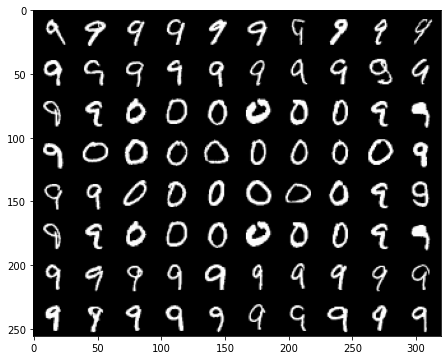

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.imshow(X_[0], cmap='gray')

In [30]:
# This should predict an array with class indices
X = torch.tensor(X_.reshape(1, X_.shape[0], X_.shape[1], X_.shape[2]))
pred = fcnn.forward(X)
pred.argmax(axis=1)

tensor([[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
         [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
         [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
         [9, 0, 0, 0, 0, 0, 0, 0, 0, 9],
         [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
         [9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
         [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
         [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]])

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Fully Convolutional Neural Network <br/>
by Christian Herta <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2021 Christian Herta

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.